In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data_dir = '/content/drive/My Drive/統計學習初論/Data/'

### EDA  
snap vs. sales  

We hope to explore the impact of the Supplemental Nutrition Assistance Program (SNAP) on sales through EDA to understand its impacts on sales, and further decide whether to include it as one of the predictive features.

SNAP Program: https://www.feedingamerica.org/take-action/advocate/federal-hunger-relief-programs/snap







In [ ]:
sells_train = pd.read_csv(data_dir + "sales_train_validation.csv")
sells_train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [ ]:
sells_train.shape

(30490, 1919)

From the above, we have a total of 30,490 rows of data, with each data having 1,919 columns. These columns include basic information about the products and its sales volume from d_1 to d_1913.

Next, read the data from "calendar.csv."

In [ ]:
calendar = pd.read_csv(data_dir + "calendar.csv")
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [ ]:
calendar.shape

(1969, 14)

**day_extraction(calendar, snap, state, end_day)**

Extract specific days based on the parameters and return an array containing those days.

- calendar: the calendar data used
- snap: 1 for snap = True, 0 for snap = False.
- state: one of the three states - "CA," "TX," or "WI" (since the snap dates vary for each state
- end_day, default = 1913: The end date for extraction

In [ ]:
def day_extraction(calendar, snap, state, end_day = 1913):
    snap2value = lambda x: 1 if x==True else 0
    value = snap2value(snap)
    stateName = 'snap_' + state
    day_list = calendar[calendar[stateName] == value].loc[:, 'd'].values.tolist()
    for i in range(len(day_list)-1, 0, -1):
        if int(day_list[i][-4:]) > 1913:
            day_list.pop()
        else:
            break
    return np.array(day_list)

#### State vs snap

In [ ]:
state_list = sells_train['state_id'].value_counts().index.tolist()
days_list = []
mean_with_snap = []
mean_without_snap = []
for i in range(len(state_list)):
    days_list.append(day_extraction(calendar, snap = True, state = state_list[i]))
    days_list.append(day_extraction(calendar, snap = False, state = state_list[i]))
    mean_with_snap.append(sells_train[(sells_train['state_id'] == state_list[i])].loc[:, days_list[2*i]].mean().mean())
    mean_without_snap.append(sells_train[(sells_train['state_id'] == state_list[i])].loc[:, days_list[2*i+1]].mean().mean())

d = {'state' : state_list*2, 'mean' : mean_with_snap + mean_without_snap ,'snap':['With snap']*3 + ['Without snap']*3}
snap_df = pd.DataFrame(d)

In [ ]:
snap_df

,state,mean,snap
0,CA,1.293202,With snap
1,WI,1.176733,With snap
2,TX,1.160242,With snap
3,CA,1.197590,Without snap
4,WI,0.966274,Without snap
5,TX,1.040678,Without snap


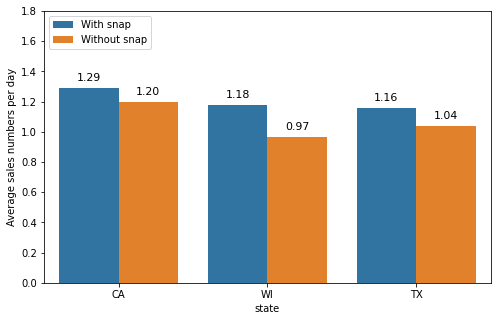

In [ ]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(x="state", hue="snap", y="mean", data=snap_df)
ax.set_ylabel("Average sales numbers per day")
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='black', xytext=(0, 10),
         textcoords='offset points')
_ = ax.set_ylim(0,1.8)
plt.legend(loc='upper left')
plt.show()
plt.close()

In [ ]:
snap_compare = snap_df.iloc[:3, :2].copy()
snap_compare.columns = ['State', 'Mean_with_snap']
snap_compare['Mean_without_snap'] = snap_df.iloc[3:,1].tolist()
snap_compare['Growth with snap(%)'] = (snap_compare['Mean_with_snap'] /snap_compare['Mean_without_snap'] - 1)*100
snap_compare

,State,Mean_with_snap,Mean_without_snap,Growth with snap(%)
0,CA,1.293202,1.197590,7.983615
1,WI,1.176733,0.966274,21.780524
2,TX,1.160242,1.040678,11.489051


We can learn from the above that snap has a positive impact on sales in all states, although the degree of impact varies slightly.

##### Product category vs snap
Analyze snap's impact on the sales volume of each product category in all states.

In [ ]:
item_cat_list = sells_train['cat_id'].value_counts().index.tolist()
item_cat_list

['FOODS', 'HOUSEHOLD', 'HOBBIES']

In [ ]:
state_list = sells_train['state_id'].value_counts().index.tolist()
days_list = []
mean_with_snap = []
mean_without_snap = []
for i in range(len(state_list)):
    days_list.append(day_extraction(calendar, snap = True, state = state_list[i]))
    days_list.append(day_extraction(calendar, snap = False, state = state_list[i]))
    for j in range(len(item_cat_list)):
      mean_with_snap.append(sells_train[(sells_train['state_id'] == state_list[i]) & (sells_train['cat_id']==item_cat_list[j])]\
                            .loc[:, days_list[2*i]].mean().mean())
      mean_without_snap.append(sells_train[(sells_train['state_id'] == state_list[i])& (sells_train['cat_id']==item_cat_list[j])]\
                               .loc[:, days_list[2*i+1]].mean().mean())

In [ ]:
state_list_dup = state_list*3
state_list_dup.sort()
d = {'state' : state_list_dup*2, 'mean' : mean_with_snap + mean_without_snap ,'cat_id':item_cat_list*6, 'snap':['With snap']*9 + ['Without snap']*9}
snap_df = pd.DataFrame(d)
snap_df['state_cat_id'] = snap_df['state'] + '_' + snap_df['cat_id']
snap_df

,state,mean,cat_id,snap,state_cat_id
0,CA,1.862391,FOODS,With snap,CA_FOODS
1,CA,0.822962,HOUSEHOLD,With snap,CA_HOUSEHOLD
2,CA,0.716944,HOBBIES,With snap,CA_HOBBIES
3,TX,1.855156,FOODS,With snap,TX_FOODS
4,TX,0.629186,HOUSEHOLD,With snap,TX_HOUSEHOLD
5,TX,0.465915,HOBBIES,With snap,TX_HOBBIES
6,WI,1.727489,FOODS,With snap,WI_FOODS
7,WI,0.739282,HOUSEHOLD,With snap,WI_HOUSEHOLD
8,WI,0.497606,HOBBIES,With snap,WI_HOBBIES
9,CA,1.688498,FOODS,Without snap,CA_FOODS


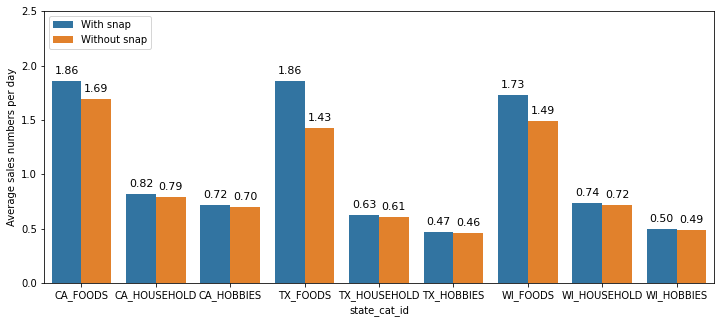

In [ ]:
plt.figure(figsize=(12, 5))
ax = sns.barplot(x="state_cat_id", hue="snap", y="mean", data=snap_df)
ax.set_ylabel("Average sales numbers per day")
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='black', xytext=(0, 10),
         textcoords='offset points')
_ = ax.set_ylim(0,2.5)
plt.legend(loc='upper left')
plt.show()
plt.close()

Observing the plot above, we can know that snap only has significant impact on FOODS sales.

#### Store vs snap

In [ ]:
stores = sells_train['store_id'].value_counts()
stores

CA_3    3049
WI_1    3049
TX_2    3049
WI_2    3049
TX_3    3049
CA_1    3049
CA_4    3049
WI_3    3049
TX_1    3049
CA_2    3049
Name: store_id, dtype: int64

In [ ]:
stores_id = stores.index.tolist()
stores_id.sort()

days_list = []
mean_with_snap = []
mean_without_snap = []
for i in range(len(stores_id)):
    state = stores_id[i][:2]
    days_list.append(day_extraction(calendar, snap = True, state = state ))
    days_list.append(day_extraction(calendar, snap = False, state = state))
    mean_with_snap.append(sells_train[(sells_train['store_id'] == stores_id[i])].loc[:, days_list[2*i]].mean().mean())
    mean_without_snap.append(sells_train[(sells_train['store_id'] == stores_id[i])].loc[:, days_list[2*i+1]].mean().mean())
# print(mean_with_snap)
# print(mean_without_snap)

stores_df = pd.DataFrame({'Store_id':stores_id*2, 'Mean':mean_with_snap + mean_without_snap, 'snap':['With snap']*10 + ['Without snap']*10})

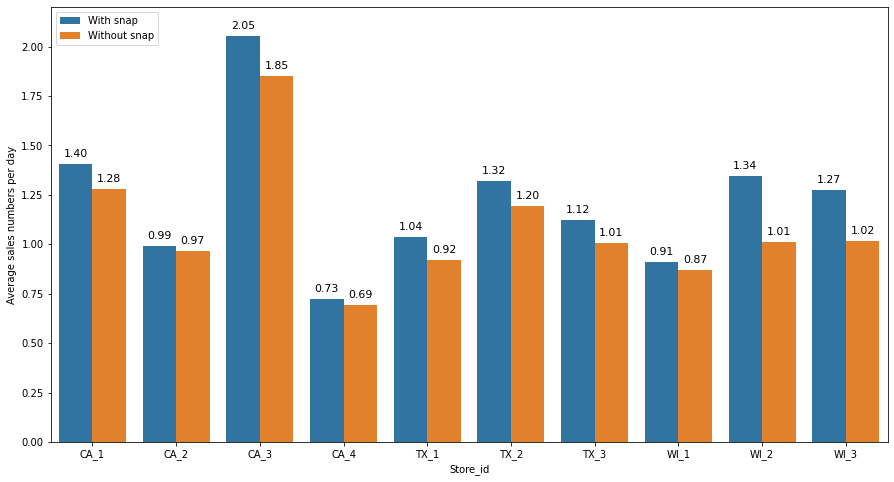

In [ ]:
plt.figure(figsize=(15, 8))
ax = sns.barplot(x="Store_id", hue="snap", y="Mean", data=stores_df)
ax.set_ylabel("Average sales numbers per day")
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='black', xytext=(0, 10),
         textcoords='offset points')
_ = ax.set_ylim(0,2.2)
plt.legend(loc='upper left')
plt.show()
plt.close()

In [ ]:
stores_compare_df = pd.DataFrame({'Store_id':stores_id, 'Mean_with_snap' : mean_with_snap, 'Mean_without_snap':mean_without_snap})
stores_compare_df['Growth with snap(%)'] =(stores_compare_df['Mean_with_snap']/stores_compare_df['Mean_without_snap']-1)*100
stores_compare_df

,Store_id,Mean_with_snap,Mean_without_snap,Growth with snap(%)
0,CA_1,1.404695,1.278157,9.900020
1,CA_2,0.989801,0.967363,2.319564
2,CA_3,2.053171,1.851879,10.869611
3,CA_4,0.725139,0.692963,4.643196
4,TX_1,1.037879,0.920702,12.726939
5,TX_2,1.319730,1.196195,10.327314
6,TX_3,1.123118,1.005138,11.737714
7,WI_1,0.911159,0.868855,4.868974
8,WI_2,1.344542,1.012642,32.775676
9,WI_3,1.274498,1.017324,25.279434


From the above, it is known that most stores are affected by snap. The impact varies across stores, with some experiencing a more significant impact than others.



#### **Conclusion**

Regardless of the aspects, whether by state, product category, or store, we observe a correlation between the presence or absence of snap and sales volume. Therefore, snap appears to be valuable information. When making predictions, incorporating snap as a feature is recommended to enhance the accuracy of the model.